In [1]:
import gymnasium as gym
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
class BlackjackAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Q-Learning agent."""
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """Choose an action using epsilon-greedy strategy."""
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Update Q-value based on experience."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        target = reward + self.discount_factor * future_q_value
        temporal_difference = target - self.q_values[obs][action]
        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        """Reduce exploration rate after each episode."""
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)
    
    def save(self, filename):
        """Save the trained Q-table and agent parameters."""
        save_data = {
            'q_values': dict(self.q_values),
            'lr': self.lr,
            'discount_factor': self.discount_factor,
            'epsilon': self.epsilon,
            'epsilon_decay': self.epsilon_decay,
            'final_epsilon': self.final_epsilon,
            'training_error': self.training_error
        }
        
        with open(f"{filename}.pkl", 'wb') as f:
            pickle.dump(save_data, f)
        
        print(f"Agent saved to {filename}.pkl")

    def load(self, filename):
        """Load a previously saved agent."""
        with open(f"{filename}.pkl", 'rb') as f:
            save_data = pickle.load(f)
        
        self.q_values = defaultdict(lambda: np.zeros(self.env.action_space.n))
        self.q_values.update(save_data['q_values'])
        
        self.lr = save_data['lr']
        self.discount_factor = save_data['discount_factor']
        self.epsilon = save_data['epsilon']
        self.epsilon_decay = save_data['epsilon_decay']
        self.final_epsilon = save_data['final_epsilon']
        self.training_error = save_data['training_error']
        
        print(f"Agent loaded from {filename}.pkl")

In [8]:
# Hyperparameters
n_episodes = 100_000
learning_rate = 0.01
start_epsilon = 1.0
final_epsilon = 0.1
epsilon_decay = start_epsilon / (n_episodes / 2)

# Env
env = gym.make("Blackjack-v1", sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

# Agent
agent = BlackjackAgent(env, learning_rate, start_epsilon, epsilon_decay, final_epsilon)

# Training Loop
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        agent.update(obs, action, reward, terminated, next_obs)
        obs, done = next_obs, terminated or truncated
    agent.decay_epsilon()


100%|██████████| 100000/100000 [00:12<00:00, 8291.05it/s]


In [4]:
agent.save("blackjack")

Agent saved to blackjack.pkl


In [5]:
!pip install gymnasium


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


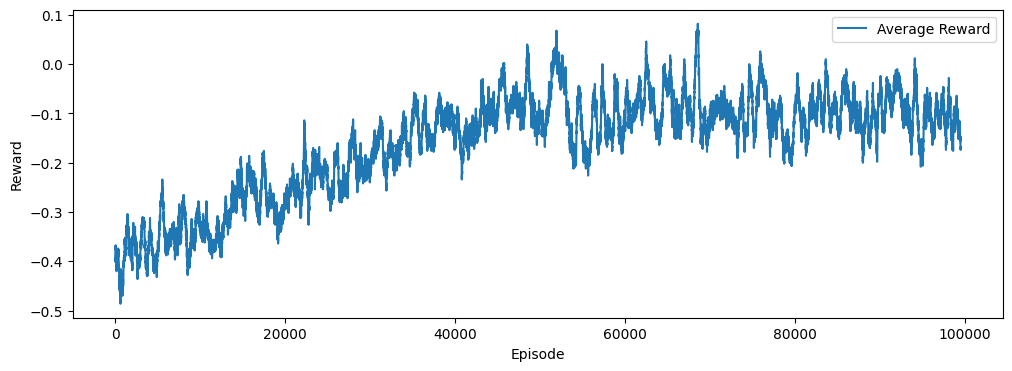

In [9]:
def moving_avg(data, window=500):
    return np.convolve(data, np.ones(window), mode="valid") / window

plt.figure(figsize=(12,4))
plt.plot(moving_avg(env.return_queue), label="Average Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()


In [7]:
def test_agent(agent, env, num_episodes=1000):
    rewards = []
    old_eps = agent.epsilon
    agent.epsilon = 0.0  # no exploration

    for _ in range(num_episodes):
        obs, info = env.reset()
        done, total_reward = False, 0
        while not done:
            action = agent.get_action(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            done = terminated or truncated
        rewards.append(total_reward)

    agent.epsilon = old_eps
    print(f"Win Rate: {np.mean(np.array(rewards) > 0):.1%}")
    print(f"Average Reward: {np.mean(rewards):.3f}")

test_agent(agent, env)


Win Rate: 41.6%
Average Reward: -0.066
